# What I use to improve the baseline
* data augamentation
* test time augmentation
* nnU-Net
* ResNet block
* instance normalization
* dice loss
* SENet

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
data = np.load('../input/ustc-geo-ai20/data.npy')
label = np.load('../input/ustc-geo-ai20/label.npy')
test_data = np.load('../input/ustc-geo-ai20/new_test_data.npy')

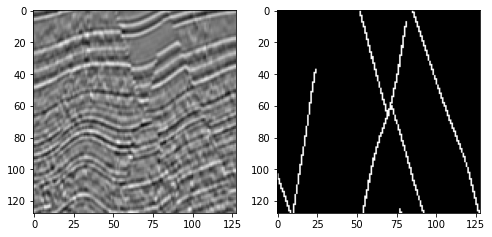

In [3]:
index = random.randint(0, len(data))

plt.figure(figsize = (8, 16))
plt.subplot(1, 2, 1)
plt.imshow(data[index], cmap = plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(label[index], cmap = plt.cm.gray)

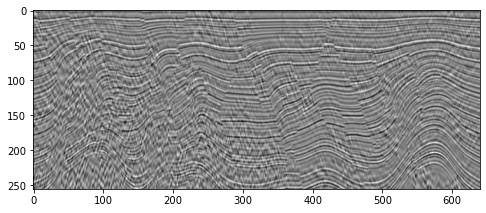

In [4]:
index = random.randint(0, len(test_data))

plt.figure(figsize = (8, 20))
plt.imshow(test_data[index], cmap = plt.cm.gray)

In [5]:
# data augmentation(DA)

for i in range(len(data)):
    mu = np.average(data[i, :])
    sigma = np.std(data[i, :])
    data[i, :] = (data[i, :] - mu) / sigma

data_h = np.flip(data, axis = 1)
data_v = np.flip(data, axis = 2)

label_h = np.flip(label, axis = 1)
label_v = np.flip(label, axis = 2)

data = np.concatenate((data, data_h, data_v))
label = np.concatenate((label, label_h, label_v))

np.random.seed(1)
np.random.shuffle(data)
np.random.seed(1)
np.random.shuffle(label)
    
test_data_h = np.flip(test_data, axis = 1)
test_data_v = np.flip(test_data, axis = 2)

data_len = len(data) # data_len == 6000

data = np.reshape(data, (data_len, 128, 128, 1))
label = np.reshape(label, (data_len, 128, 128, 1))
test_data = np.reshape(test_data, (100, 256, 640, 1))
test_data_h = np.reshape(test_data_h, (100, 256, 640, 1))
test_data_v = np.reshape(test_data_v, (100, 256, 640, 1))

train_data = data[0 : int(data_len * 0.8)]
val_data = data[int(data_len * 0.8) : data_len]
train_label = label[0 : int(data_len * 0.8)]
val_label = label[int(data_len * 0.8) : data_len]

In [6]:
# dice loss

# https://www.kaggle.com/meaninglesslives/nested-unet-with-efficientnet-encoder

from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [7]:
# resnet block
# instance normalization(IN)
# nnu-net
# SEnet

# https://github.com/zhao62/Deep-Residual-Shrinkage-Networks
# https://ieeexplore.ieee.org/document/8850096
# https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss
# https://arxiv.org/pdf/1809.10486.pdf

from IN import InstanceNormalization

def InstanceActivate(x):
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.01)(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = InstanceActivate(x)
    return x

def squeeze_excitation_block(blockInput, num_filters):
    scale = GlobalAveragePooling2D()(blockInput)
    scale = Dense(num_filters // 16, activation = 'relu')(scale)
    scale = Dense(num_filters, activation = 'sigmoid')(scale)
    scale = Reshape((1, 1, num_filters))(scale)
    x = Multiply()([blockInput, scale])
    return x
    
def residual_block(blockInput, num_filters=16, instance_activate=False):
    x = InstanceActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation = False)
    x = squeeze_excitation_block(x, num_filters)
    x = Add()([x, blockInput])
    if instance_activate:
        x = InstanceActivate(x)
    return x

ModuleNotFoundError: No module named 'IN'

In [8]:
def encoder_block(blockInput, num_filters):   
    x = Conv2D(num_filters, (3, 3), activation = None, padding = 'same')(blockInput)
    x = Conv2D(num_filters, (3, 3), activation = None, padding = 'same')(x)
    x = residual_block(x, num_filters)  
    x = residual_block(x, num_filters, True)
    y = MaxPooling2D(pool_size = (2, 2))(x)
    # y = Dropout(0.5)(y)
    
    output = {'before_pool' : x, 'after_pool' : y}
    return output
    
def decoder_block(blockInput, num_filters, *info):
    x = Conv2DTranspose(num_filters, (3, 3), strides = (2, 2), padding = "same")(blockInput)
    x = Concatenate()([x] + list(info))
    # x = Dropout(0.5)(x)
    x = Conv2D(num_filters, (3, 3), activation = None, padding = 'same')(x)
    x = Conv2D(num_filters, (3, 3), activation = None, padding = 'same')(x)
    x = residual_block(x, num_filters)
    x = residual_block(x, num_filters, True)
    
    return x

In [9]:
def unet(input_size = (None, None, 1)):

    input = Input(input_size, name = 'input')

    output_0 = encoder_block(input, 16)
    output_1 = encoder_block(output_0['after_pool'], 32)
    output_2 = encoder_block(output_1['after_pool'], 64)
    output_3 = encoder_block(output_2['after_pool'], 128)

    output_m = encoder_block(output_3['after_pool'], 256)

    output_4 = decoder_block(output_m['before_pool'], 128, output_3['before_pool'])
    output_5 = decoder_block(output_4, 64, output_2['before_pool'])
    output_6 = decoder_block(output_5, 32, output_1['before_pool'])
    output_7 = decoder_block(output_6, 16, output_0['before_pool'])
    
    output = Conv2D(1, (1, 1), activation = 'sigmoid')(output_7) 

    model = Model(inputs = [input], outputs = [output])
    model.compile(optimizer = Adam(lr = 3e-4), loss = bce_dice_loss, metrics = ['accuracy'])

    # model.summary()
    return model

In [10]:
model = unet()

filepath = './model/model.hdf5'
autosave = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = 'true', mode = 'min')
# reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, verbose = 1, mode = 'auto', min_lr = 1e-6)
callbacks_list = [autosave]

NameError: name 'residual_block' is not defined

In [11]:
history = model.fit(
    train_data, train_label, 
    batch_size = 16,
    validation_data = (val_data, val_label),
    epochs = 40,
    verbose = 1,
    shuffle = True,
    callbacks = callbacks_list
)

NameError: name 'model' is not defined

NameError: name 'history' is not defined

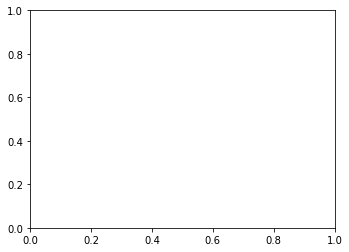

In [12]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label = 'training set')
plt.plot(history.history['val_acc'], label = 'validation set')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'training set')
plt.plot(history.history['val_loss'], label = 'validation set')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [13]:
# test time augmentation(TTA)

model = load_model("model/model.hdf5", custom_objects = {
      'InstanceNormalization' : InstanceNormalization,
      'bce_dice_loss' : bce_dice_loss
})

result_o = model.predict(test_data)
result_h = model.predict(test_data_h)
result_v = model.predict(test_data_v)

result_h = np.flip(result_h, axis = 1)
result_v = np.flip(result_v, axis = 2)

NameError: name 'InstanceNormalization' is not defined

In [14]:
result = (result_o + result_v + result_h) / 3

threshold = 0.35
result[result > threshold] = 1
result[result < threshold] = 0
result_o[result_o > threshold] = 1
result_o[result_o < threshold] = 0

index = random.randint(0, len(test_data))

plt.figure(figsize = (20, 60))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_data[index]), cmap = plt.cm.gray)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(result_o[index]), cmap = plt.cm.gray)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(result[index]), cmap = plt.cm.gray)

NameError: name 'result_o' is not defined